In [1]:
import soundfile
import numpy as np
import librosa
import glob
import os
from sklearn.model_selection import train_test_split

In [3]:
# all emotions on RAVDESS dataset
int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

# we allow only these four emotions
AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

In [6]:
"""This function is to extract features"""
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")

    # Open the audio file
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")  # Audio data
        sample_rate = sound_file.samplerate  # Sample rate

        if chroma or contrast:
            stft = np.abs(librosa.stft(X))  # Short-Time Fourier Transform

        result = np.array([])  # Initialize the result array

        if mfcc:
            # Extract MFCC features
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))

        if chroma:
            # Extract Chroma features
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, chroma))

        if mel:
            # Correct call to `melspectrogram()` using keyword arguments
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
            result = np.hstack((result, mel))

        if contrast:
            # Extract spectral contrast features
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
            result = np.hstack((result, contrast))

        if tonnetz:
            # Extract Tonnetz features (harmonic features)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
            result = np.hstack((result, tonnetz))

    return result


def load_data(test_size=0.25):
    X, y = [], []
    try:
        # Path to Actor_01 folder
        folder_path = "/content/drive/MyDrive/ALL_DATA_ML/ALL_DATA_ML/SpeechToEmotion/Actor_01"

        # Get all .wav files in the folder
        for file in glob.glob(os.path.join(folder_path, "*.wav")):
            basename = os.path.basename(file)
            print(f"Processing file: {basename}")  # Debug: check each file

            # Extract emotion based on the file name structure
            emotion = int2emotion.get(basename.split("-")[2], None)
            print(f"Emotion found: {emotion}")  # Debug: check emotion

            if emotion not in AVAILABLE_EMOTIONS:
                print(f"Skipping emotion: {emotion}")  # Debug: emotion not in AVAILABLE_EMOTIONS
                continue

            features = extract_feature(file, mfcc=True, chroma=True, mel=True)
            if features.size == 0:
                print(f"Failed to extract features for {file}")
                continue

            X.append(features)
            y.append(emotion)

        print(f"Number of samples after extraction: {len(X)}")  # Debug: check number of samples

    except Exception as e:
        print(f"Error during data loading: {e}")

    if len(X) == 0:
        raise ValueError("No valid data found after processing files.")

    # Split the data into training and testing
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)

In [7]:
# Load data with test size of 25%
X_train, X_test, y_train, y_test = load_data(test_size=0.25)

# Print some details
print("[+] Number of training samples:", X_train.shape[0])
print("[+] Number of testing samples:", X_test.shape[0])
print("[+] Number of features:", X_train.shape[1])

Processing file: 03-01-01-01-01-01-01.wav
Emotion found: neutral
Processing file: 03-01-01-01-01-02-01.wav
Emotion found: neutral
Processing file: 03-01-01-01-02-01-01.wav
Emotion found: neutral
Processing file: 03-01-01-01-02-02-01.wav
Emotion found: neutral
Processing file: 03-01-02-01-01-01-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-01-01-02-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-01-02-01-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-01-02-02-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-02-01-01-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-02-01-02-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-02-02-01-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-02-02-02-02-01.wav
Emotion found: calm
Skipping emotion: calm
Processing file: 03-01-03-01-01-01-01.wav
Emotion found: hap

[+] Training the model...
[+] Model training completed.
[+] Evaluating the model...
[+] Accuracy: 0.86
[+] Classification Report:
              precision    recall  f1-score   support

       happy       1.00      1.00      1.00         2
     neutral       1.00      0.50      0.67         2
         sad       0.75      1.00      0.86         3

    accuracy                           0.86         7
   macro avg       0.92      0.83      0.84         7
weighted avg       0.89      0.86      0.84         7



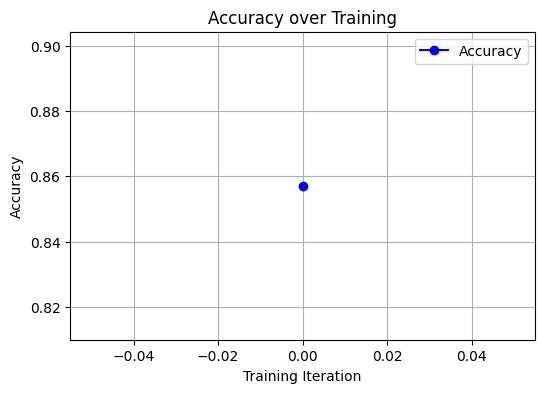

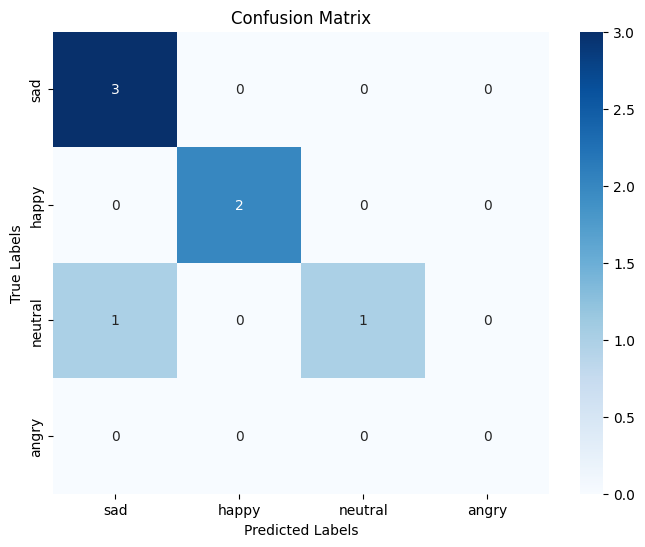

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train the Random Forest model
def train_model(X_train, y_train):
    print("[+] Training the model...")
    model = RandomForestClassifier(n_estimators=100, random_state=7)
    model.fit(X_train, y_train)
    print("[+] Model training completed.")
    return model

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    print("[+] Evaluating the model...")
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"[+] Accuracy: {accuracy:.2f}")
    print("[+] Classification Report:")
    print(classification_report(y_test, y_pred))
    return accuracy, y_pred

# Plot accuracy over training
def plot_accuracy(accuracy):
    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, marker='o', linestyle='-', color='b', label='Accuracy')
    plt.title('Accuracy over Training')
    plt.xlabel('Training Iteration')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()
    plt.show()

# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, classes):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Train and evaluate the model
model = train_model(X_train, y_train)
accuracy, y_pred = evaluate_model(model, X_test, y_test)

# Plot accuracy and confusion matrix
plot_accuracy([accuracy])  # Here, we plot only the final accuracy as a single point
plot_confusion_matrix(y_test, y_pred, classes=list(AVAILABLE_EMOTIONS))


In [9]:
def predict_emotion(file_name, model):
    """
    Predicts the emotion from a given .wav file using the trained model.

    Parameters:
        file_name (str): Path to the .wav file to predict.
        model: Trained classifier model.

    Returns:
        str: Predicted emotion.
    """
    try:
        # Extract features from the given file
        features = extract_feature(file_name, mfcc=True, chroma=True, mel=True)
        if features.size == 0:
            raise ValueError("No features extracted. Ensure the file is valid.")

        # Reshape features for prediction (1 sample with n features)
        features = features.reshape(1, -1)

        # Predict the emotion
        prediction = model.predict(features)
        predicted_emotion = prediction[0]  # Since predict returns a list

        print(f"Predicted Emotion: {predicted_emotion}")
        return predicted_emotion
    except Exception as e:
        print(f"Error during emotion prediction: {e}")
        return None


In [10]:
# Path to the .wav file you want to test
input_file = "/content/drive/MyDrive/ALL_DATA_ML/ALL_DATA_ML/SpeechToEmotion/Actor_01/03-01-01-01-01-01-01.wav"

# Predict emotion
predicted_emotion = predict_emotion(input_file, model)


Predicted Emotion: neutral


In [ ]:
def get_trained_model(test_size=0.25):
    """
    Trains the model and returns it after training.

    Parameters:
        test_size (float): Proportion of the dataset to include in the test split.

    Returns:
        tuple: A tuple containing the trained model, X_test, and y_test for evaluation.
    """
    try:
        # Load the data
        print("[+] Loading data...")
        X_train, X_test, y_train, y_test = load_data(test_size=test_size)

        # Train the model
        print("[+] Training the model...")
        model = train_model(X_train, y_train)

        print("[+] Model training completed and returned.")
        return model, X_test, y_test
    except Exception as e:
        print(f"Error during model training: {e}")
        return None, None, None